# 0. Setup

In [22]:
import numpy as np
from numpy.testing import assert_almost_equal
import pandas as pd
from matplotlib import pyplot as plt

from scipy.optimize import minimize

from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')



In [4]:
### Helper functions

def covariance_calc(H, k):
    #Calculation derived in dissertation.
    
    return 0.5\
        * (np.abs(k - 1) ** (2 * H)\
         + np.abs(k + 1) ** (2 * H)\
         - 2 * (np.abs(k) ** (2 * H)))

#Test basic functionality. Numbers calculated by hand
assert_almost_equal(covariance_calc(0.5, 1), 0)
assert_almost_equal(covariance_calc(0.25, 1), -0.2928932)
assert_almost_equal(covariance_calc(0.25, -1), -0.2928932)
assert_almost_equal(covariance_calc(0.75, 4), 0.1882461)

def get_covariance_matrix(n_steps, H):
    #Return an unscaled covariance matrix
    m = np.zeros([n_steps , n_steps])
    k = np.arange(0, n_steps, 1)
    m[:, 0] = covariance_calc(H, k)

    for i in range(1, n_steps):
        m[i:, i] = m[i-1:-1, i-1]
    
    m = np.tril(m) + np.triu(m.T, 1)
    return m

#Test matrix build right. Numbers calculated by hand. 
assert_almost_equal(get_covariance_matrix(3, 0.25), np.array([[1, -0.2928932, -0.0481881], [-0.2928932, 1, -0.2928932], [-0.0481881, -0.2928932, 1]]))



In [5]:
def simulate_fbm(n_sims, n_steps, T, H):

    rng = np.random.default_rng(seed = 1729)

    cov_mat = get_covariance_matrix(n_steps, H)
    L = np.linalg.cholesky(cov_mat)
    
    variates = rng.normal(loc = 0, scale = 1, size = [n_sims, n_steps])
    corr_variates = (L @ variates.T).T

    B = np.zeros([n_sims, n_steps + 1])

    for i in range(0, n_steps):
        B[:, i + 1] = B[:, i] + corr_variates[:, i]

    return B * (T/n_steps) ** (H)


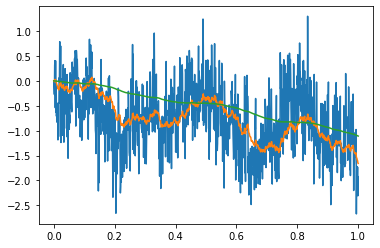

In [6]:
n_steps = 1024
T = 1

span = np.linspace(0, T, n_steps + 1)

out = simulate_fbm(1, n_steps, T, 0.05)
plt.plot(span, out.T)

out = simulate_fbm(1, n_steps, T, 0.5)
plt.plot(span, out.T)

out = simulate_fbm(1, n_steps, T, 0.95)
plt.plot(span, out.T)

# 1. MLE

In [7]:
def H_estimator(x, T):
    #return estimator of H from dissertation. Assume q = 2. 
    n_steps = x.shape[0]
    
    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    diffs = diffs = x[1:] - x[:-1]

    return np.log(np.dot(diffs, diffs)) / np.log(T / n_steps)


def obj(H, x, T):
    n_steps = x.shape[0]
    R = get_covariance_matrix(n_steps, H)
    scalar = (T / n_steps) ** (2 * H)

    determinant = np.linalg.det(R)
    R_inv = np.linalg.inv(R) / scalar

    return np.log(determinant) + n_steps * np.log(scalar) + n_steps * np.log(1 / n_steps * np.dot(x.T, np.dot(R_inv, x))) 
    


def max_MLE(x, T):

    #Add x_0 value if it is missing
    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    
    diffs = x[1:] - x[:-1]

    #initial_guess = H_estimator(x, T)
    initial_guess = 0.5

    #Convergence issues noticed around H = 0.95, setting a bound of 0.94
    #Set lower bound of floating epsilon to stop H hitting exactly 0, which will cause LLF errors
    H = minimize(obj, initial_guess, args = (diffs, T), bounds = [(np.finfo(float).eps, 0.94)], method = "Powell", tol = 1e-10)

    if H.success:
        H_hat = H.x[0]
        R = get_covariance_matrix(n_steps, H_hat)
        scalar = (T / n_steps) ** (2 * H_hat)
        R_inv = np.linalg.inv(R) / scalar
        sigma_hat = np.sqrt(1 / n_steps * np.dot(diffs.T, np.dot(R_inv, diffs)))
        return H_hat, sigma_hat

    return H.success

In [8]:
# Check this code works for a selection of cases

test_vals = np.arange(0.05, 0.9, 0.05)
test_scalars = np.arange(0.5, 2, 0.5)
val_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
scalar_errors = np.zeros((test_vals.shape[0], test_scalars.shape[0]))
for i, i_val in enumerate(test_vals):
    print(i_val)
    for j, j_val in enumerate(test_scalars):
        print(j_val)
        test_sim = simulate_fbm(1, 1024, 1, i_val)
        test_sim = test_sim[0, :].T * j_val
        test_H = max_MLE(test_sim, 1)
        val_errors[i, j] = test_H[0] - i_val
        scalar_errors[i, j] = test_H[1] - j_val
    

0.05
0.5
1.0
1.5
0.1
0.5
1.0
1.5
0.15000000000000002
0.5
1.0
1.5
0.2
0.5
1.0
1.5
0.25
0.5
1.0
1.5
0.3
0.5
1.0
1.5
0.35000000000000003
0.5
1.0
1.5
0.4
0.5
1.0
1.5
0.45
0.5
1.0
1.5
0.5
0.5
1.0
1.5
0.55
0.5
1.0
1.5
0.6000000000000001
0.5
1.0
1.5
0.6500000000000001
0.5
1.0
1.5
0.7000000000000001
0.5
1.0
1.5
0.7500000000000001
0.5
1.0
1.5
0.8
0.5
1.0
1.5
0.8500000000000001
0.5
1.0
1.5


In [9]:
val_errors

array([[0.0028441 , 0.00284409, 0.00284408],
       [0.00267591, 0.00267592, 0.00267592],
       [0.00276498, 0.00276498, 0.00276499],
       [0.00301798, 0.00301794, 0.00301798],
       [0.00334684, 0.00334684, 0.00334687],
       [0.00369966, 0.00369965, 0.00369965],
       [0.00404885, 0.00404889, 0.00404887],
       [0.00438125, 0.00438125, 0.00438126],
       [0.00469182, 0.00469178, 0.00469176],
       [0.00497959, 0.00497965, 0.00497974],
       [0.00524652, 0.00524646, 0.00524632],
       [0.00549444, 0.00549435, 0.00549412],
       [0.00572622, 0.00572595, 0.00572553],
       [0.00594178, 0.00594178, 0.00594164],
       [0.00613998, 0.00613995, 0.00613908],
       [0.00630617, 0.00630617, 0.00630602],
       [0.08999999, 0.08999999, 0.08999999]])

In [10]:
scalar_errors

array([[-3.87268574e-03, -7.74539135e-03, -1.16181647e-02],
       [-3.81815954e-03, -7.63629382e-03, -1.14544426e-02],
       [-3.27262786e-03, -6.54529531e-03, -9.81783994e-03],
       [-2.28483702e-03, -4.56990859e-03, -6.85448986e-03],
       [-1.06128485e-03, -2.12258790e-03, -3.18364697e-03],
       [ 2.59206801e-04,  5.18360840e-04,  7.77463860e-04],
       [ 1.60062830e-03,  3.20149760e-03,  4.80207372e-03],
       [ 2.92907153e-03,  5.85814306e-03,  8.78722900e-03],
       [ 4.23728239e-03,  8.47425437e-03,  1.27111938e-02],
       [ 5.53437415e-03,  1.10691536e-02,  1.66047227e-02],
       [ 6.84511105e-03,  1.36897981e-02,  2.05331642e-02],
       [ 8.20336425e-03,  1.64060734e-02,  2.46066383e-02],
       [ 9.66354543e-03,  1.93250066e-02,  2.89827515e-02],
       [ 1.12992308e-02,  2.25984617e-02,  3.38960550e-02],
       [ 1.32397320e-02,  2.64791678e-02,  3.97079542e-02],
       [ 1.56896592e-02,  3.13793184e-02,  4.70669613e-02],
       [ 8.53391862e-01,  1.70678372e+00

In [11]:
sample_fbm = np.loadtxt('C:\\Users\\jamma\\Masters\\Dissertation\\fBMPath2.txt')
sample_fbm.shape[0]

1024

In [12]:
sample_fbm = np.loadtxt('C:\\Users\jamma\Masters\Dissertation\\fBMPath2.txt')
sample_fbm.shape[0]

1024

In [13]:
max_MLE(sample_fbm, 1)


(0.035675424351465715, 1.1596978410643553)

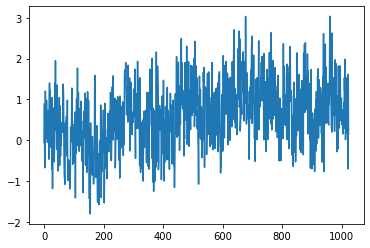

In [14]:
plt.plot(sample_fbm)

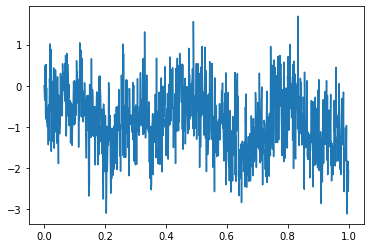

In [15]:
out = simulate_fbm(1, 1024, 1, 0.03567489)
plt.plot(span, out.T * 1.1596978410643428)

In [26]:
acf(sample_fbm)

array([1.        , 0.33848197, 0.31445334, 0.30954273, 0.29733704,
       0.26233198, 0.24912878, 0.23509667, 0.2081714 , 0.21143256,
       0.20427162, 0.16674153, 0.21128202, 0.19593047, 0.21519629,
       0.18828065, 0.1851257 , 0.1896319 , 0.22788662, 0.21026438,
       0.17973199, 0.17808322, 0.17909835, 0.21371549, 0.18227513,
       0.15862594, 0.2065785 , 0.1673337 , 0.19986595, 0.17457819,
       0.15667411])

In [27]:
acf(out[0])

array([1.        , 0.35192507, 0.32260599, 0.31302013, 0.30046703,
       0.29365595, 0.26963148, 0.27641732, 0.24912008, 0.23062974,
       0.25376984, 0.25135622, 0.22123991, 0.23976797, 0.21292123,
       0.21528403, 0.19959168, 0.18586337, 0.15951894, 0.19646439,
       0.19219081, 0.19452567, 0.17250649, 0.17200722, 0.17417323,
       0.24172247, 0.19554366, 0.20571181, 0.1722152 , 0.16121628,
       0.18225341])